In [49]:
import requests
import json
import time
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
Notre projet portera sur le jeu League of Legends. C’est un jeu d’équipe en ligne
en 5 contre 5. Vous pouvez si vous le souhaitez regarder un tutoriel de 3 minutes
si vous avez envie de vous familiariser avec le jeu pour avoir une meilleure
compréhension globale sur le thème de notre projet.
https://www.youtube.com/watch?v=0MEOdboHk8o&ab_channel=GentleMates

# 1 - Collection de notre jeu de données

Pour collecter nos données, nous sommes directement allés les chercher à la source en se branchant à l’api du jeu. On y récupère les noms des meilleurs joueurs du serveur européen. On fait ce choix car ces parties de haut niveaux sont moins hasardeuses et il en découlera des données plus fiables.

Il faut aussi prendre en compte les restrictions de l’api concernant le nombre de requêtes, on a pour cela créé plusieurs comptes particuliers afin de faire des requêtes en parrallèles sur plus de comptes.

Nous avons séparé tout le processus de requêtes api dans le fichier api_process. Ce fichier contiendra le code en rapport direct avec les jalons et le rendu final du projet.

Update jalon 2 : Même si nous en avions l'intuition, prédire l'issue d'une partie en prenant ses caractéristiques à l'instant final de la fin de la partie est trop simple (1 d'accuracy dès la régression logistique en cross validation sur un jeu de test). On revoit donc tout le data set pour prendre des informations de partie à un instant t (exemple : 10, 20 minutes) de la partie pour en prédire son issue. On aura donc des résultats plus pertinents avec une vraie utilité avec un peu plus de challenge

In [50]:
matchs_info_df = pd.read_csv('matchs_info_2900.csv') #import of dataset created by api_process.ipynb

In [51]:
print(matchs_info_df.columns)

Index(['win', 'allInPings', 'assistMePings', 'assists', 'baronKills',
       'basicPings', 'bountyLevel', 'champExperience', 'champLevel',
       'championTransform',
       ...
       'challenges.fastestLegendary', 'challenges.firstTurretKilledTime',
       'challenges.soloTurretsLategame', 'challenges.highestChampionDamage',
       'challenges.highestWardKills', 'challenges.thirdInhibitorDestroyedTime',
       'challenges.shortestTimeToAceFromFirstTakedown',
       'challenges.fasterSupportQuestCompletion',
       'challenges.earliestElderDragon', 'challenges.hadAfkTeammate'],
      dtype='object', length=207)


In [52]:
"""
    ONLY USE THIS CELL IF YOU WANT TO FILTER THE DATASET
    Remove spoilers columns and columns that are not useful for the analysis
"""

#Move win column to index 1 (for easier debugging)
matchs_info_df = matchs_info_df[['win'] + [col for col in matchs_info_df.columns if col != 'win']]
toRemove = ['championId', 'championName', 'gameEndedInEarlySurrender', 'gameEndedInSurrender', 'inhibitorsLost','item0', 'item1', 'item2', 'item3', 'item4', 'item5', 'item6', 'nexusKills','nexusLost','nexusTakedowns','participantId','placement','playerAugment1','playerAugment2','playerAugment3','playerAugment4', 'playerScore0', 'playerScore1', 'playerScore3', 'playerScore4', 'playerScore5', 'playerScore6', 'playerScore7', 'playerScore8', 'playerScore9', 'playerScore10', 'playerScore11', 'playerSubteamId', 'profileIcon', 'puuid', 'riotIdGameName', 'riotIdTagline', 'role', 'subteamPlacement', 'summonerName', 'teamEarlySurrendered', 'teamId', 'teamPosition', 'challenges.dancedWithRiftHerald', 'challenges.killsOnRecentlyHealedByAramPack', 'challenges.killsWithHelpFromEpicMonster', 'challenges.lostAnInhibitor', 'challenges.outnumberedNexusKill', 'challenges.poroExplosions', 'challenges.snowballsHit', 'challenges.unseenRecalls','missions.playerScore0','missions.playerScore1','missions.playerScore2','missions.playerScore3','missions.playerScore4','missions.playerScore5','missions.playerScore6','missions.playerScore7','missions.playerScore8','missions.playerScore9','missions.playerScore10','missions.playerScore11', 'perks.statPerks.defense', 'perks.statPerks.flex', 'perks.statPerks.offense', 'perks.styles', 'challenges.teleportTakedowns', 'challenges.highestCrowdControlScore', 'challenges.earliestBaron', 'eligibleForProgression', 'gameEndedInEarlySurrender', 'lane', 'largestCriticalStrike', 'nexusKills', 'nexusLost', 'nexusTakedowns','individualPosition', 'summonerId','challenges.legendaryItemUsed','challenges.moreEnemyJungleThanOpponent', 'challenges.legendaryItemUsed', 'summonerId', 'individualPosition']
matchs_info_df_non_filtre = matchs_info_df
print(matchs_info_df_non_filtre.columns)


Index(['win', 'allInPings', 'assistMePings', 'assists', 'baronKills',
       'basicPings', 'bountyLevel', 'champExperience', 'champLevel',
       'championTransform',
       ...
       'challenges.fastestLegendary', 'challenges.firstTurretKilledTime',
       'challenges.soloTurretsLategame', 'challenges.highestChampionDamage',
       'challenges.highestWardKills', 'challenges.thirdInhibitorDestroyedTime',
       'challenges.shortestTimeToAceFromFirstTakedown',
       'challenges.fasterSupportQuestCompletion',
       'challenges.earliestElderDragon', 'challenges.hadAfkTeammate'],
      dtype='object', length=207)


In [53]:
try : 
    matchs_info_df = matchs_info_df.drop(columns=toRemove,axis=1, inplace=True)
except KeyError:
    print("Columns were already removed from the dataset") 

Columns were already removed from the dataset


In [54]:
#we group the data to get 1 matchs = 2 lines and 1 line = one team of the game
matchs_info_test = matchs_info_df.groupby(np.arange(len(matchs_info_df))//5).sum()
pd.set_option('display.max_columns', None)
print(matchs_info_test.columns)

Index(['win', 'allInPings', 'assistMePings', 'assists', 'baronKills',
       'basicPings', 'bountyLevel', 'champExperience', 'champLevel',
       'championTransform',
       ...
       'challenges.fastestLegendary', 'challenges.firstTurretKilledTime',
       'challenges.soloTurretsLategame', 'challenges.highestChampionDamage',
       'challenges.highestWardKills', 'challenges.thirdInhibitorDestroyedTime',
       'challenges.shortestTimeToAceFromFirstTakedown',
       'challenges.fasterSupportQuestCompletion',
       'challenges.earliestElderDragon', 'challenges.hadAfkTeammate'],
      dtype='object', length=207)


In [55]:
#we get the two teams to put them on the same line and have a line = a match

#We get all the blue teams
equipes_1 = matchs_info_test.iloc[::2]
equipes_1.reset_index(inplace=True)
equipes_1.drop(columns = 'index', inplace = True)

#We get all the red teams
equipes_2 = matchs_info_test.iloc[1::2]
equipes_2.reset_index(inplace=True)
equipes_2.drop(columns = 'index', inplace = True)



/tmp/ipykernel_15036/1725581550.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  equipes_1.drop(columns = 'index', inplace = True)
/tmp/ipykernel_15036/1725581550.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  equipes_2.drop(columns = 'index', inplace = True)


In [56]:
equipes_1

win  allInPings  assistMePings  assists  baronKills  basicPings  \
0       5          10             52       53           2           0   
1       5           4              7       74           1           0   
2       0           0             28       23           0           0   
3       0           1              4       15           0           0   
4       5          13             51       54           1           0   
...   ...         ...            ...      ...         ...         ...   
3838    0           0             37       66           1           0   
3839    0           6             32       53           0           0   
3840    5           6             48       53           1           0   
3841    0           5              8       16           0           0   
3842    0           1              4       28           0           0   

      bountyLevel  champExperience  champLevel  championTransform  \
0              16            76252          78                  0   
1               9            72084          77                  2   
2               0            44885          59                  0   
3               1            51233          64                  0   
4               1            73516          77                  0   
...           ...              ...         ...                ...   
3838            1            74780          78                  0   
3839            0            70681          75                  0   
3840           10            75051          78                  0   
3841            0            49733          63                  0   
3842            0            55555          68                  0   

      commandPings  consumablesPurchased  damageDealtToBuildings  \
0               82                    33                   16971   
1               28                    18                   25142   
2               34                    19                   12308   
3               37                    13                   10292   
4               97                    38                   17393   
...            ...                   ...                     ...   
3838            40                    26                    8412   
3839            58                    18                    5308   
3840            43                    20                   29850   
3841            38                    10                    5558   
3842             8                    26                    1912   

      damageDealtToObjectives  damageDealtToTurrets  damageSelfMitigated  \
0                       80671                 16971               143109   
1                       89125                 25142                84676   
2                       38095                 12308                94651   
3                       44376                 10292                66732   
4                       37231                 17393               122815   
...                       ...                   ...                  ...   
3838                    48310                  8412               195351   
3839                    43028                  5308               115893   
3840                    94259                 29850               103114   
3841                    26607                  5558                88853   
3842                    29152                  1912                71193   

      dangerPings  deaths  detectorWardsPlaced  doubleKills  dragonKills  \
0               0      33                   23            3            1   
1               0      24                    6            6            1   
2               0      31                    6            2            0   
3               0      41                    6            0            0   
4               0      36                   23            3            0   
...           ...     ...                  ...          ...          ...   
3838            0      37             

In [57]:
equipes_2

win  allInPings  assistMePings  assists  baronKills  basicPings  \
0       0           0             21       56           0           0   
1       0           0             22       36           0           0   
2       5           4             11       38           1           0   
3       5           6             32       78           1           0   
4       0           1              9       60           0           0   
...   ...         ...            ...      ...         ...         ...   
3838    5          29             41       57           0           0   
3839    5          32             60       55           1           0   
3840    0          16             39       27           0           0   
3841    5          14             29       37           1           0   
3842    5           5             28       56           1           0   

      bountyLevel  champExperience  champLevel  championTransform  \
0               0            65874          73                  0   
1               0            58202          68                  2   
2              14            58965          68                  0   
3              17            62811          71                  0   
4               0            67486          74                  0   
...           ...              ...         ...                ...   
3838            7            73914          78                  0   
3839            6            74642          78                  0   
3840            0            63306          72                  0   
3841           15            69770          75                  0   
3842           10            68334          75                  0   

      commandPings  consumablesPurchased  damageDealtToBuildings  \
0               23                    16                   10820   
1               44                    11                    6090   
2               27                    18                   24120   
3               58                    25                   21218   
4               34                    36                   29385   
...            ...                   ...                     ...   
3838            90                    26                   23645   
3839            80                    22                   32074   
3840            59                    21                    8509   
3841            37                    20                   25171   
3842            77                    27                   28127   

      damageDealtToObjectives  damageDealtToTurrets  damageSelfMitigated  \
0                       63552                 10820               101925   
1                       29829                  6090                97738   
2                       79973                 24120                74817   
3                       65393                 21218               111961   
4                      103011                 29385               126487   
...                       ...                   ...                  ...   
3838                    86068                 23645               117201   
3839                   114875                 32074                99083   
3840                    29656                  8509                68300   
3841                   100292                 25171                58541   
3842                    74615                 28127                61616   

      dangerPings  deaths  detectorWardsPlaced  doubleKills  dragonKills  \
0               0      30                    8            1            3   
1               0      51                    3            3            2   
2               0      17                   10            5            3   
3               0      18                   15            3            3   
4               0      30                   25            3            4   
...           ...     ...                  ...          ...          ...   
3838            0      38             

In [58]:
#Concat columns of equipes_1 and equipes_2 with _0 et _1 suffix to get 207 * 2 nb of columns
matchs_dataset = pd.concat([equipes_1.add_suffix('_0'), equipes_2.add_suffix('_1')], axis=1) 

In [59]:
matchs_dataset

win_0  allInPings_0  assistMePings_0  assists_0  baronKills_0  \
0         5            10               52         53             2   
1         5             4                7         74             1   
2         0             0               28         23             0   
3         0             1                4         15             0   
4         5            13               51         54             1   
...     ...           ...              ...        ...           ...   
3838      0             0               37         66             1   
3839      0             6               32         53             0   
3840      5             6               48         53             1   
3841      0             5                8         16             0   
3842      0             1                4         28             0   

      basicPings_0  bountyLevel_0  champExperience_0  champLevel_0  \
0                0             16              76252            78   
1                0              9              72084            77   
2                0              0              44885            59   
3                0              1              51233            64   
4                0              1              73516            77   
...            ...            ...                ...           ...   
3838             0              1              74780            78   
3839             0              0              70681            75   
3840             0             10              75051            78   
3841             0              0              49733            63   
3842             0              0              55555            68   

      championTransform_0  commandPings_0  consumablesPurchased_0  \
0                       0              82                      33   
1                       2              28                      18   
2                       0              34                      19   
3                       0              37                      13   
4                       0              97                      38   
...                   ...             ...                     ...   
3838                    0              40                      26   
3839                    0              58                      18   
3840                    0              43                      20   
3841                    0              38                      10   
3842                    0               8                      26   

      damageDealtToBuildings_0  damageDealtToObjectives_0  \
0                        16971                      80671   
1                        25142                      89125   
2                        12308                      38095   
3                        10292                      44376   
4                        17393                      37231   
...                        ...                        ...   
3838                      8412                      48310   
3839                      5308                      43028   
3840                     29850                      94259   
3841                      5558                      26607   
3842                      1912                      29152   

      damageDealtToTurrets_0  damageSelfMitigated_0  dangerPings_0  deaths_0  \
0                      16971                 143109              0        33   
1                      25142                  84676              0        24   
2                      12308                  94651              0        31   
3                      10292                  66732              0        41   
4                      17393                 122815              0        36   
...                      ...                    ...            ...       ...   
3838                    8412                 195351              0        37   
3839                    5308                 115893              0        37   
3840                   29850  

In [60]:
matchs_dataset
#TO DO ONE TIME bcs columns are already renamed or dropped
wins = matchs_dataset['win_0']/5
matchs_dataset['win_0'] = wins
matchs_dataset.drop(columns='win_1', inplace=True)
matchs_dataset.rename(columns = {'win_0':'win'}, inplace = True)


In [61]:
#We get the columns that are categorical to check if we dont need to do some hot encoding
from sklearn.compose import make_column_selector as selector 

categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(matchs_dataset)
categorical_columns

[]

In [62]:
matchs_dataset.drop_duplicates(inplace=True) #remove duplicates even if there should not be any

In [63]:
matchs_dataset

win  allInPings_0  assistMePings_0  assists_0  baronKills_0  \
0     1.0            10               52         53             2   
1     1.0             4                7         74             1   
2     0.0             0               28         23             0   
3     0.0             1                4         15             0   
4     1.0            13               51         54             1   
...   ...           ...              ...        ...           ...   
3838  0.0             0               37         66             1   
3839  0.0             6               32         53             0   
3840  1.0             6               48         53             1   
3841  0.0             5                8         16             0   
3842  0.0             1                4         28             0   

      basicPings_0  bountyLevel_0  champExperience_0  champLevel_0  \
0                0             16              76252            78   
1                0              9              72084            77   
2                0              0              44885            59   
3                0              1              51233            64   
4                0              1              73516            77   
...            ...            ...                ...           ...   
3838             0              1              74780            78   
3839             0              0              70681            75   
3840             0             10              75051            78   
3841             0              0              49733            63   
3842             0              0              55555            68   

      championTransform_0  commandPings_0  consumablesPurchased_0  \
0                       0              82                      33   
1                       2              28                      18   
2                       0              34                      19   
3                       0              37                      13   
4                       0              97                      38   
...                   ...             ...                     ...   
3838                    0              40                      26   
3839                    0              58                      18   
3840                    0              43                      20   
3841                    0              38                      10   
3842                    0               8                      26   

      damageDealtToBuildings_0  damageDealtToObjectives_0  \
0                        16971                      80671   
1                        25142                      89125   
2                        12308                      38095   
3                        10292                      44376   
4                        17393                      37231   
...                        ...                        ...   
3838                      8412                      48310   
3839                      5308                      43028   
3840                     29850                      94259   
3841                      5558                      26607   
3842                      1912                      29152   

      damageDealtToTurrets_0  damageSelfMitigated_0  dangerPings_0  deaths_0  \
0                      16971                 143109              0        33   
1                      25142                  84676              0        24   
2                      12308                  94651              0        31   
3                      10292                  66732              0        41   
4                      17393                 122815              0        36   
...                      ...                    ...            ...       ...   
3838                    8412                 195351              0        37   
3839                    5308                 115893              0        37   
3840                   29850                 103114   

In [64]:
matchs_dataset.to_csv('matchs_dataset.csv', index = False)

# Visualisation du dataset

In [65]:
import requests
import json
import time
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle

In [66]:
data = pd.read_csv('matchs_dataset.csv')
target = data['win']

In [67]:
target

0       1.0
1       1.0
2       0.0
3       0.0
4       1.0
       ... 
3838    0.0
3839    0.0
3840    1.0
3841    0.0
3842    0.0
Name: win, Length: 3843, dtype: float64

In [68]:
data_to_display = data[data.columns[:len(data.columns)//2]] #For histogram display, we dont want to display red team stats
data_sample = data.sample(2000) #Sample 2000 rows to work with
data_to_display

win  allInPings_0  assistMePings_0  assists_0  baronKills_0  \
0     1.0            10               52         53             2   
1     1.0             4                7         74             1   
2     0.0             0               28         23             0   
3     0.0             1                4         15             0   
4     1.0            13               51         54             1   
...   ...           ...              ...        ...           ...   
3838  0.0             0               37         66             1   
3839  0.0             6               32         53             0   
3840  1.0             6               48         53             1   
3841  0.0             5                8         16             0   
3842  0.0             1                4         28             0   

      basicPings_0  bountyLevel_0  champExperience_0  champLevel_0  \
0                0             16              76252            78   
1                0              9              72084            77   
2                0              0              44885            59   
3                0              1              51233            64   
4                0              1              73516            77   
...            ...            ...                ...           ...   
3838             0              1              74780            78   
3839             0              0              70681            75   
3840             0             10              75051            78   
3841             0              0              49733            63   
3842             0              0              55555            68   

      championTransform_0  commandPings_0  consumablesPurchased_0  \
0                       0              82                      33   
1                       2              28                      18   
2                       0              34                      19   
3                       0              37                      13   
4                       0              97                      38   
...                   ...             ...                     ...   
3838                    0              40                      26   
3839                    0              58                      18   
3840                    0              43                      20   
3841                    0              38                      10   
3842                    0               8                      26   

      damageDealtToBuildings_0  damageDealtToObjectives_0  \
0                        16971                      80671   
1                        25142                      89125   
2                        12308                      38095   
3                        10292                      44376   
4                        17393                      37231   
...                        ...                        ...   
3838                      8412                      48310   
3839                      5308                      43028   
3840                     29850                      94259   
3841                      5558                      26607   
3842                      1912                      29152   

      damageDealtToTurrets_0  damageSelfMitigated_0  dangerPings_0  deaths_0  \
0                      16971                 143109              0        33   
1                      25142                  84676              0        24   
2                      12308                  94651              0        31   
3                      10292                  66732              0        41   
4                      17393                 122815              0        36   
...                      ...                    ...            ...       ...   
3838                    8412                 195351              0        37   
3839                    5308                 115893              0        37   
3840                   29850                 103114   

# Histogrammes 

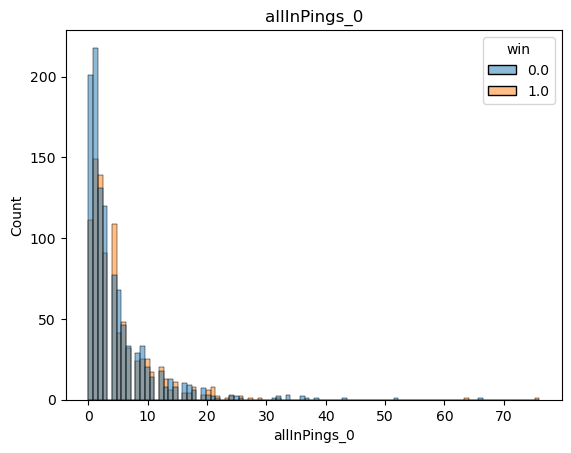

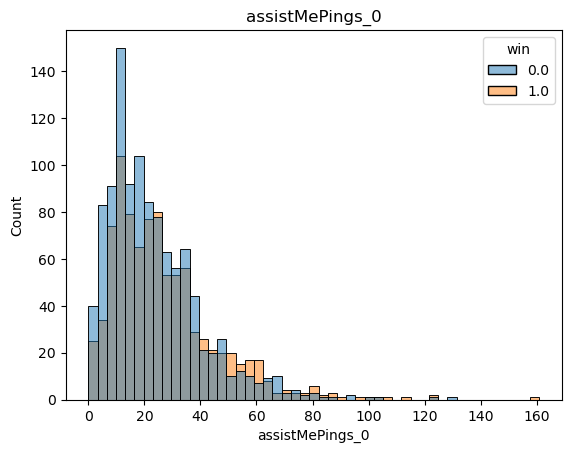

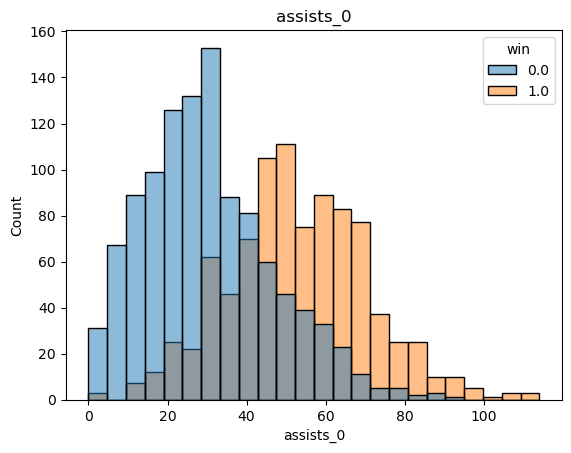

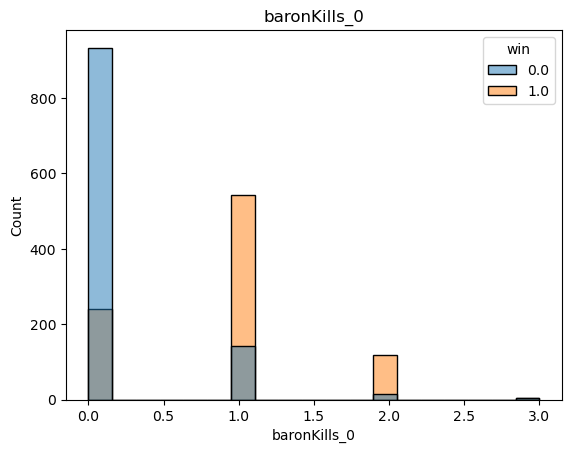

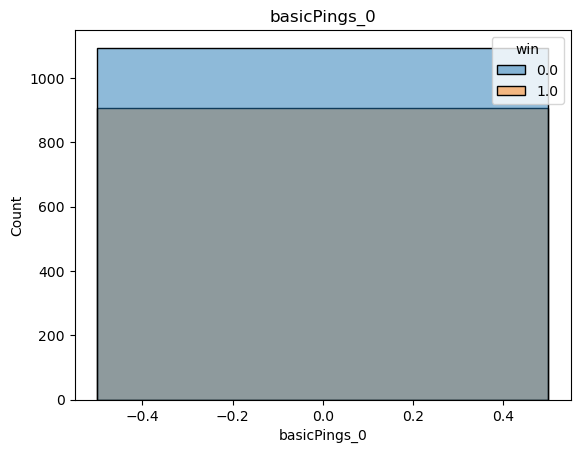

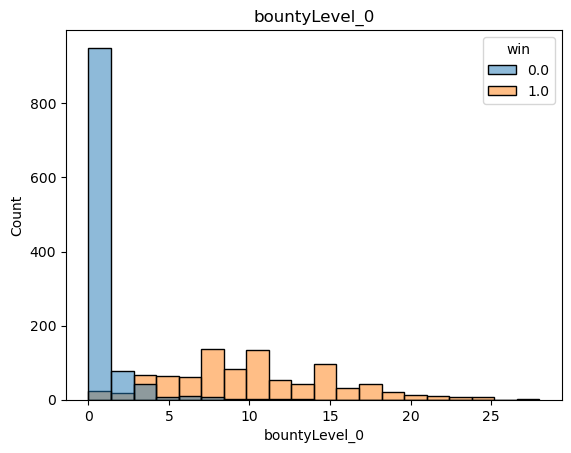

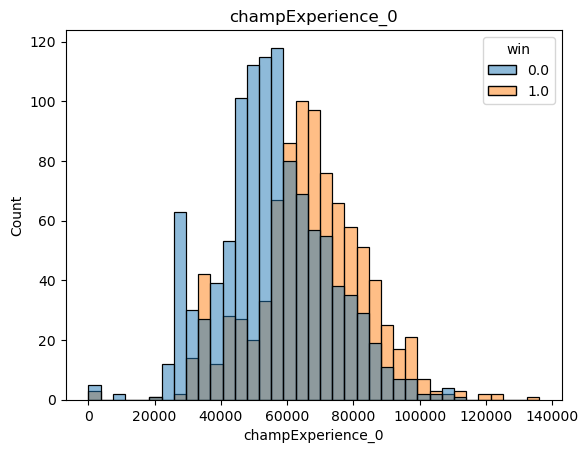

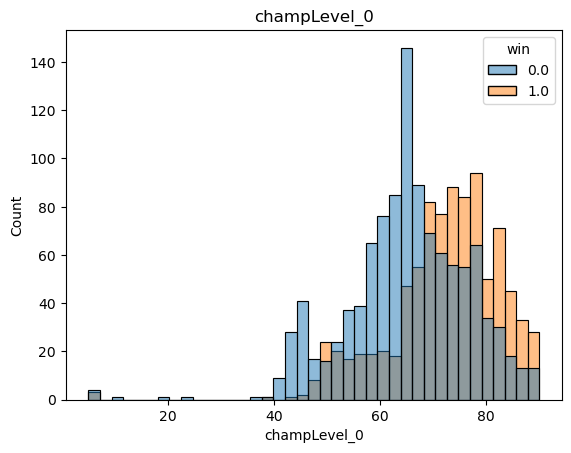

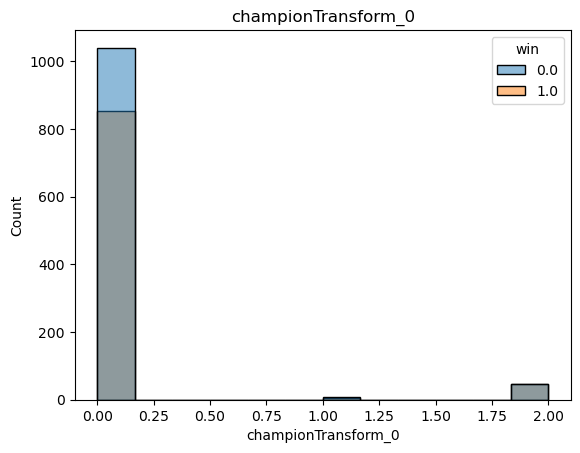

In [69]:
#We take the first half of the dataset to display variables distribution with seaborn
#display the distribution of the variables

plt.figsize=(20,20)
for col in data_to_display.columns[1:10]: #We display from column 1 to 10
    sns.histplot(data_sample, x=col, hue=target)
    plt.title(col)
    plt.show()

In [70]:
data_to_display.describe()

win  allInPings_0  assistMePings_0    assists_0  baronKills_0  \
count  3843.000000   3843.000000      3843.000000  3843.000000   3843.000000   
mean      0.449649      4.594067        24.534999    40.069737      0.480094   
std       0.497523      5.829986        17.831737    20.668307      0.634187   
min       0.000000      0.000000         0.000000     0.000000      0.000000   
25%       0.000000      1.000000        12.000000    24.000000      0.000000   
50%       0.000000      3.000000        20.000000    38.000000      0.000000   
75%       1.000000      6.000000        33.000000    55.000000      1.000000   
max       1.000000     76.000000       173.000000   114.000000      3.000000   

       basicPings_0  bountyLevel_0  champExperience_0  champLevel_0  \
count        3843.0    3843.000000        3843.000000   3843.000000   
mean            0.0       4.900859       60266.040333     68.037731   
std             0.0       5.906816       17925.609806     11.752806   
min             0.0       0.000000           0.000000      5.000000   
25%             0.0       0.000000       47991.500000     61.000000   
50%             0.0       2.000000       60638.000000     69.000000   
75%             0.0       9.000000       71865.000000     76.000000   
max             0.0      28.000000      136150.000000     90.000000   

       championTransform_0  commandPings_0  consumablesPurchased_0  \
count          3843.000000     3843.000000             3843.000000   
mean              0.098361       46.144418               21.172001   
std               0.424037       24.790097                7.807972   
min               0.000000        0.000000                3.000000   
25%               0.000000       28.000000               16.000000   
50%               0.000000       42.000000               20.000000   
75%               0.000000       60.000000               26.000000   
max               2.000000      199.000000               66.000000   

       damageDealtToBuildings_0  damageDealtToObjectives_0  \
count               3843.000000                3843.000000   
mean               15180.089774               58499.239396   
std                 9487.070439               32968.850326   
min                    0.000000                   0.000000   
25%                 6866.000000               30529.000000   
50%                13867.000000               56438.000000   
75%                23754.000000               84180.000000   
max                54862.000000              191811.000000   

       damageDealtToTurrets_0  damageSelfMitigated_0  dangerPings_0  \
count             3843.000000            3843.000000         3843.0   
mean             15180.089774           92179.357013            0.0   
std               9487.070439           46066.338481            0.0   
min                  0.000000              92.000000            0.0   
25%               6866.000000           61305.000000            0.0   
50%              13867.000000           85409.000000            0.0   
75%              23754.000000          115822.000000            0.0   
max              54862.000000          403254.000000            0.0   

         deaths_0  detectorWardsPlaced_0  doubleKills_0  dragonKills_0  \
count  3843.00000            3843.000000    3843.000000    3843.000000   
mean     27.20791              11.105386       2.388499       1.383034   
std      10.68055               6.185580       1.963419       1.203649   
min       0.00000               0.000000       0.000000       0.000000   
25%      20.00000               7.000000       1.000000       0.000000   
50%      28.00000              10.000000       2.000000       1.000000   
75%      35.00000              15.000000       4.000000       2.000000   
max      61.00000              44.000000      12.000000       5.000000   

       enemyMissingPings_0  enemyVisionPings_0  firstBloodAssist_0  \
count          3843.000000         3843.000000         3843.000000   
mean             

# Graphs

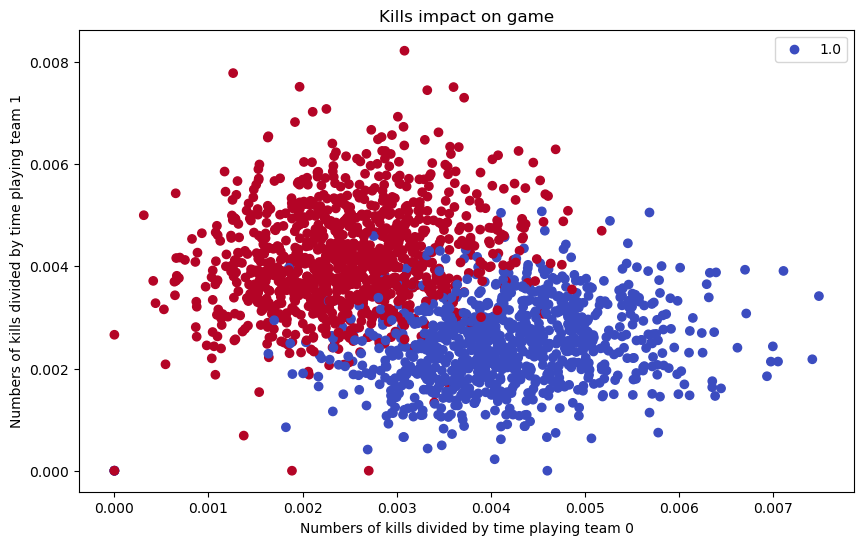

In [71]:
plt.figure(figsize=(10,6))
plt.title('Kills impact on game')
plt.scatter(data_sample['kills_0']/data_sample["timePlayed_0"], data_sample['kills_1']/data_sample["timePlayed_1"], c=data_sample["win"], cmap='coolwarm_r')
plt.xlabel('Numbers of kills divided by time playing team 0')
plt.ylabel('Numbers of kills divided by time playing team 1')
plt.legend(data_sample['win']) 
plt.show()

We can see that the team with more kills tends to win the game more often. Even though there is still an area where it is hard to predict.

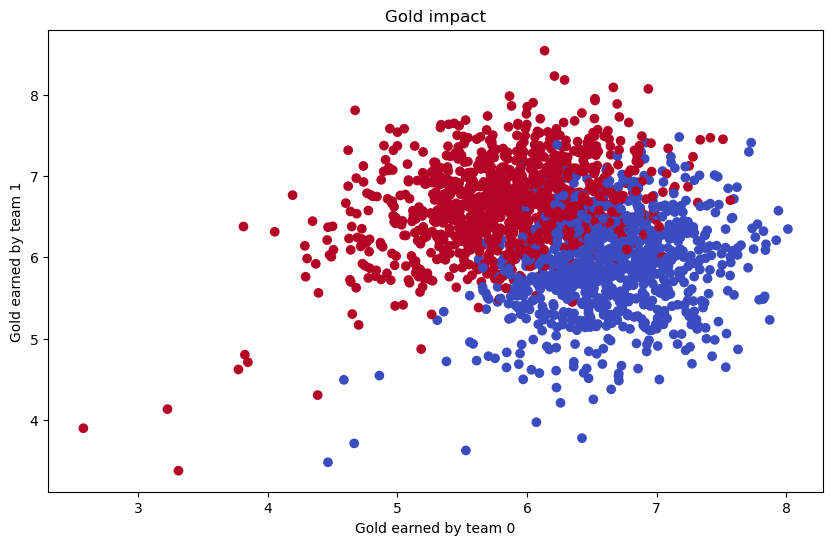

In [72]:
#Impact of golds spent on the game normalized by time played in
plt.figure(figsize=(10,6))
plt.title('Gold impact')
plt.scatter(data_sample["goldSpent_0"]/data_sample["timePlayed_0"],data_sample['goldSpent_1']/data_sample["timePlayed_1"] , c=data_sample["win"], cmap='coolwarm_r')
plt.xlabel('Gold earned by team 0')
plt.ylabel('Gold earned by team 1') 
plt.show()

We can see that the team with more golds spent tends to win the game more often. Even though there is still an area where it is hard to predict.

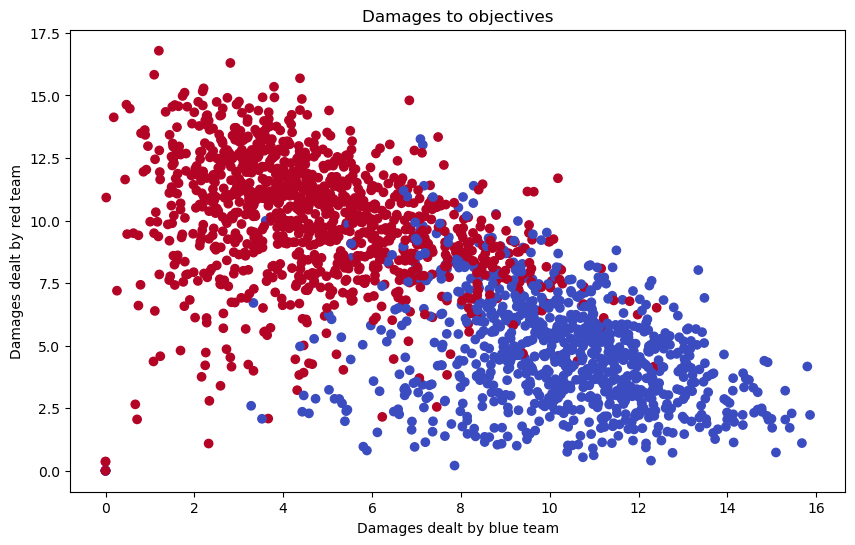

In [73]:
#Damages to objectives and its impact on game
plt.figure(figsize=(10,6))
plt.title('Damages to objectives')
plt.scatter(data_sample['damageDealtToObjectives_0']/data_sample['timePlayed_0'], data_sample['damageDealtToObjectives_1']/data_sample['timePlayed_1'], c=data_sample["win"], cmap='coolwarm_r')
plt.xlabel('Damages dealt by blue team')
plt.ylabel('Damages dealt by red team')
plt.show()

We can see that the team with more damages dealt tends to win the game more often. Even though there is still an area where it is hard to predict.

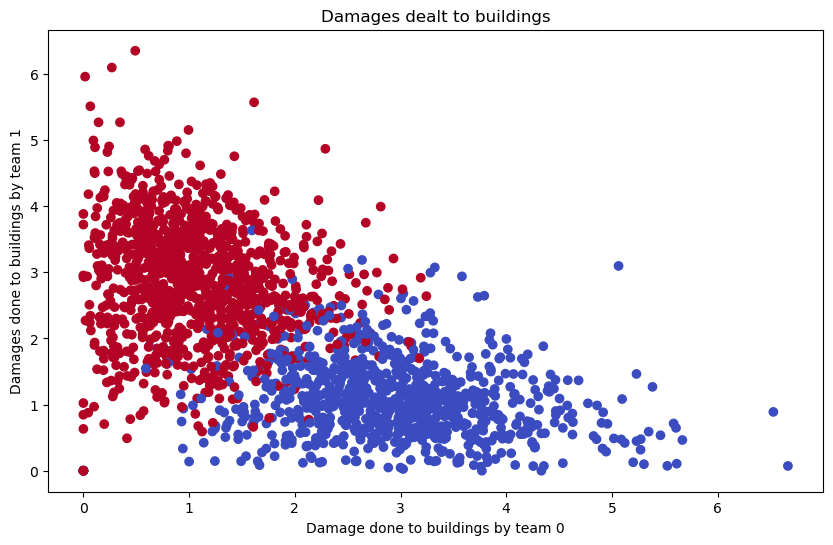

In [74]:
#Damages to buildings by teams and its impact on the game
plt.figure(figsize=(10,6))
plt.title("Damages dealt to buildings")
plt.scatter(data_sample['damageDealtToBuildings_0']/data_sample['timePlayed_0'], data_sample['damageDealtToBuildings_1']/data_sample['timePlayed_1'], c=data_sample["win"], cmap='coolwarm_r')
plt.xlabel('Damage done to buildings by team 0')
plt.ylabel('Damages done to buildings by team 1')
plt.show()

We can see that the team with more damages done to buildings tends to win the game more often. Even though there is still an area where it is hard to predict.

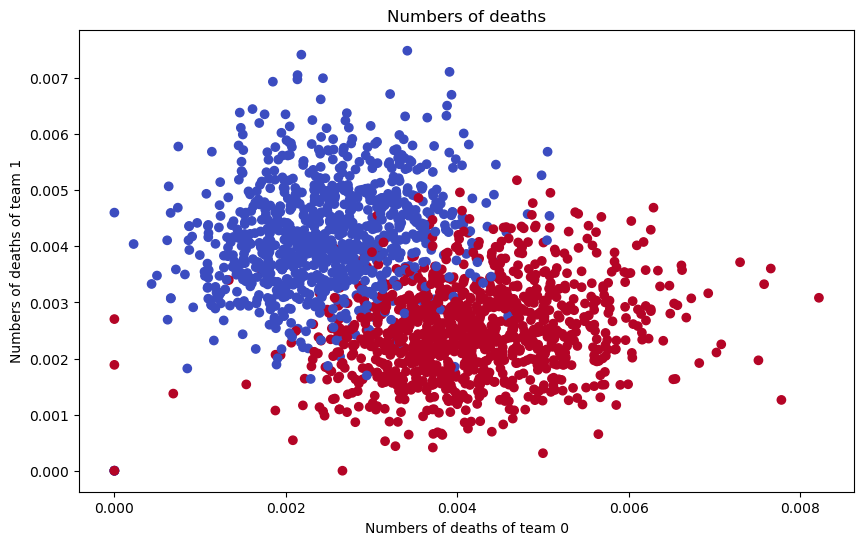

In [75]:
#Numbers of deaths and its impact on the game
plt.figure(figsize=(10,6))
plt.title("Numbers of deaths")
plt.scatter(data_sample['deaths_0']/data_sample['timePlayed_0'], data_sample['deaths_1']/data_sample['timePlayed_1'], c=data_sample["win"], cmap='coolwarm_r')
plt.xlabel('Numbers of deaths of team 0')
plt.ylabel('Numbers of deaths of team 1')
plt.show()

We can see that the team with more deaths tends to lose the game more often, which should be normal when kills and deaths are complementary.

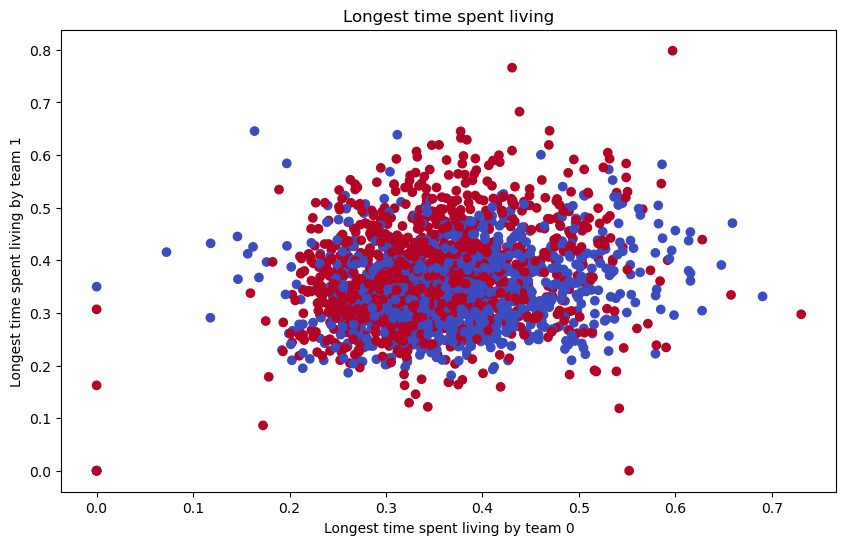

In [76]:
#Longest time alive of a team and its impact on the game
plt.figure(figsize=(10,6))
plt.title('Longest time spent living')
plt.scatter(data_sample['longestTimeSpentLiving_0']/data_sample['timePlayed_0'], data_sample['longestTimeSpentLiving_1']/data_sample['timePlayed_1'], c=data_sample["win"], cmap='coolwarm_r')
plt.xlabel('Longest time spent living by team 0')
plt.ylabel('Longest time spent living by team 1')
plt.show()

We can imagine that having the longest time living in games is not a winning condition.

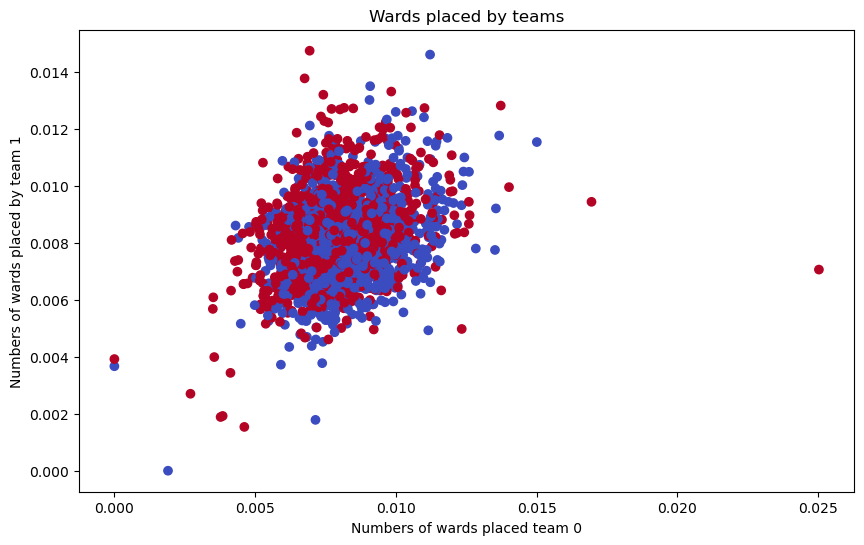

In [77]:
#Wards placed by teams
plt.figure(figsize=(10,6))
plt.title('Wards placed by teams')
plt.scatter(data_sample['wardsPlaced_0']/data_sample['timePlayed_0'], data_sample['wardsPlaced_1']/data_sample['timePlayed_1'], c=data_sample["win"], cmap='coolwarm_r')
plt.xlabel('Numbers of wards placed team 0')
plt.ylabel('Numbers of wards placed by team 1')
plt.show()

We can imagine putting a lot of wards in games is not a winning condition.

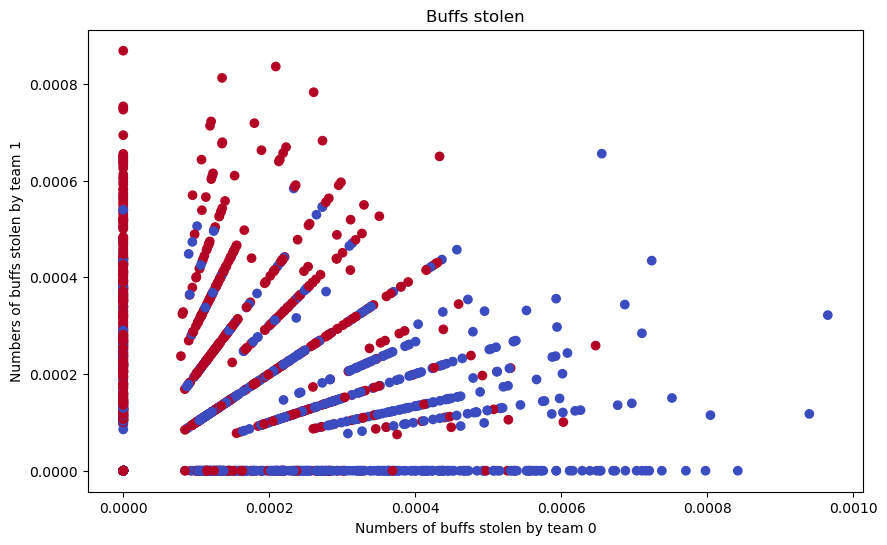

In [78]:
#Bonus buffs stolen in ennemy team
plt.figure(figsize=(10,6))
plt.title('Buffs stolen')
plt.scatter(data_sample["challenges.buffsStolen_0"]/data_sample['timePlayed_0'], data_sample["challenges.buffsStolen_1"]/data_sample['timePlayed_1'], c=data_sample["win"], cmap='coolwarm_r')
plt.xlabel('Numbers of buffs stolen by team 0')
plt.ylabel('Numbers of buffs stolen by team 1')
plt.show()

We can see that stealing buffs to ennemy team give a lead to win games.

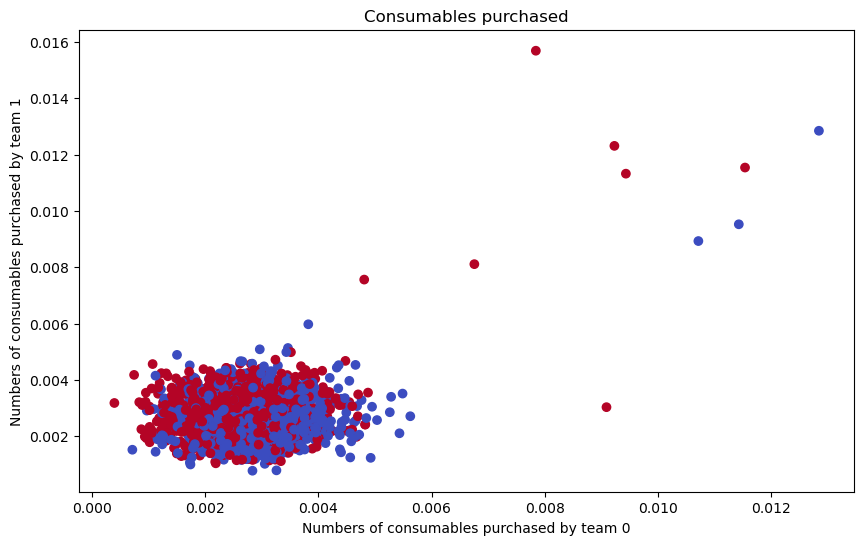

In [79]:
#ZOOM DESSUS
plt.figure(figsize=(10,6))
plt.title('Consumables purchased')
plt.scatter(data_sample["consumablesPurchased_0"]/data_sample['timePlayed_0'], data_sample["consumablesPurchased_1"]/data_sample['timePlayed_1'], c=data_sample["win"], cmap='coolwarm_r')
plt.xlabel('Numbers of consumables purchased by team 0')
plt.ylabel('Numbers of consumables purchased by team 1')
plt.show()

We see that a lot of players buy around the same number of consumables and at first glance we cant determine if this impacts the result of the game. We have a more accurate look of the area.

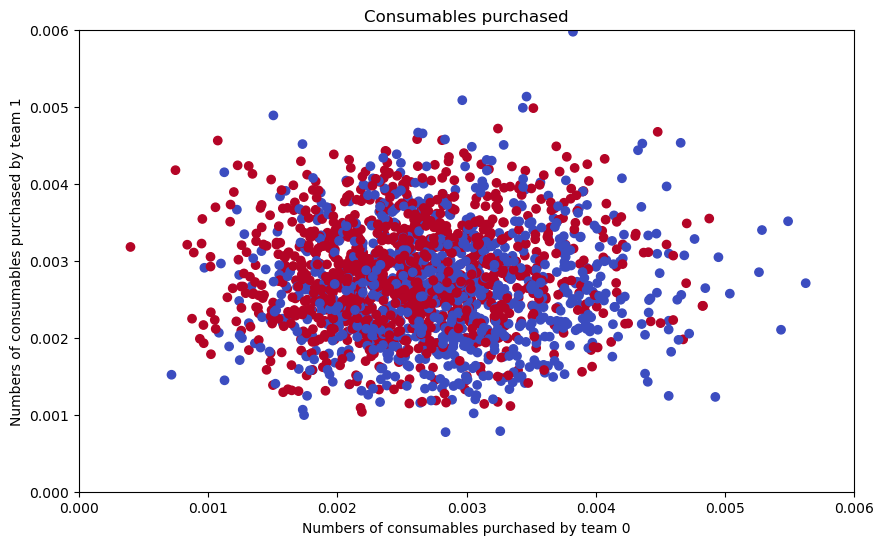

In [80]:
#ZOOM DESSUS
plt.figure(figsize=(10,6))
plt.title('Consumables purchased')
plt.xlabel('Numbers of consumables purchased by team 0')
plt.ylabel('Numbers of consumables purchased by team 1')
plt.xlim(0, 0.006)
plt.ylim(0, 0.006)
plt.scatter(data_sample["consumablesPurchased_0"]/data_sample['timePlayed_0'], data_sample["consumablesPurchased_1"]/data_sample['timePlayed_1'], c=data_sample["win"], cmap='coolwarm_r')
plt.show()

As we said, consumables dont have much impact on the game.

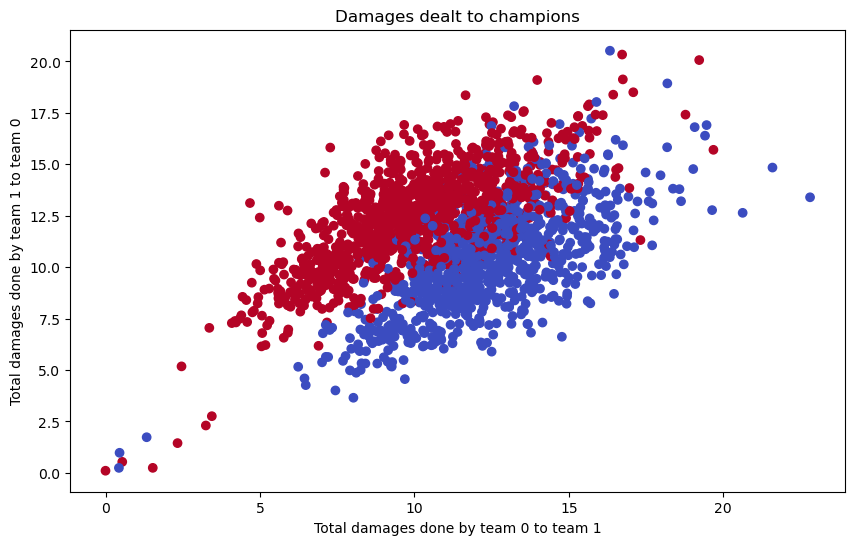

In [81]:
plt.figure(figsize=(10,6))
plt.title("Damages dealt to champions")
plt.scatter(data_sample["totalDamageDealtToChampions_0"]/data_sample['timePlayed_0'], data_sample["totalDamageDealtToChampions_1"]/data_sample['timePlayed_1'], c=data_sample["win"], cmap='coolwarm_r')
plt.xlabel('Total damages done by team 0 to team 1')
plt.ylabel('Total damages done by team 1 to team 0')
plt.show()

We can see that the team with more deaths tends to lose the game more often, which should be normal when kills and deaths are complementary.

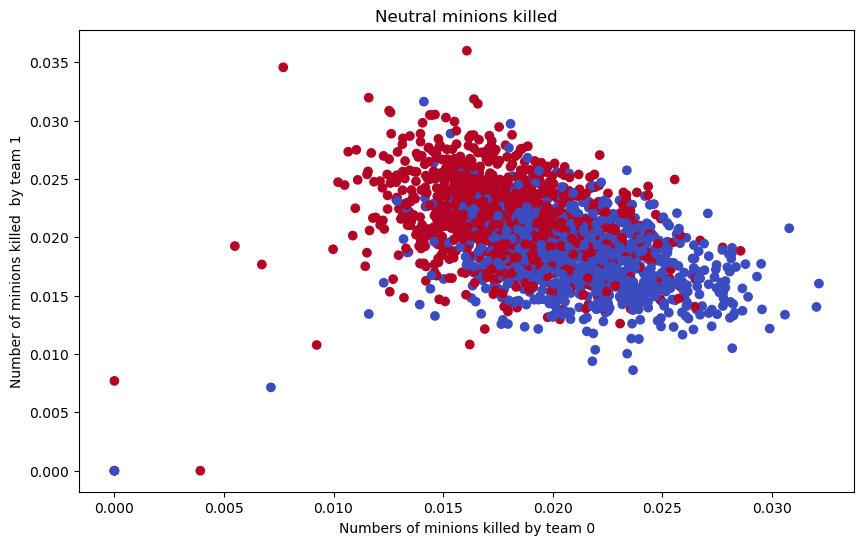

In [82]:
plt.figure(figsize=(10,6))
plt.title('Neutral minions killed')
plt.scatter(data_sample["neutralMinionsKilled_0"]/data_sample['timePlayed_0'], data_sample["neutralMinionsKilled_1"]/data_sample['timePlayed_1'], c=data_sample["win"], cmap='coolwarm_r')
plt.xlabel('Numbers of minions killed by team 0')
plt.ylabel('Number of minions killed  by team 1')
plt.show()

We can see that the team with more minions killed tends to win the game more often, which should be normal because minions give golds and experience and we saw before that they were a win condition.

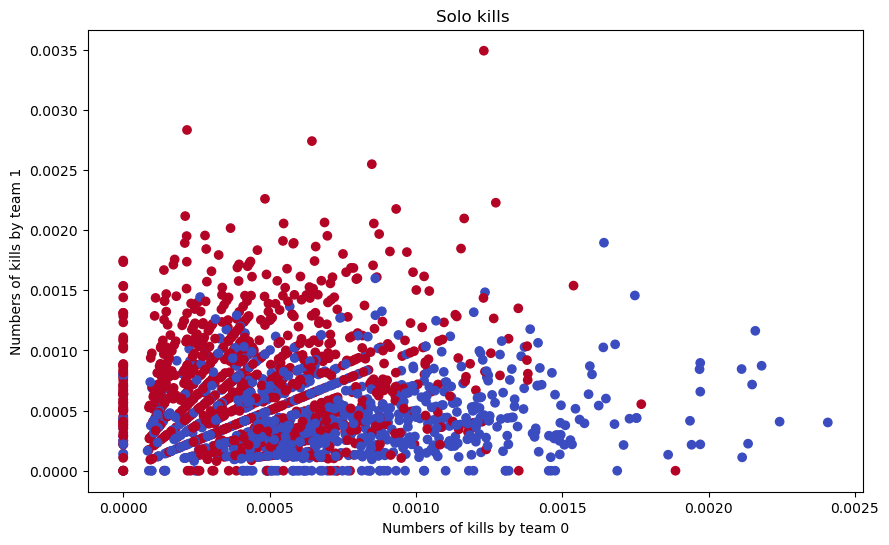

In [83]:
plt.figure(figsize=(10,6))
plt.title('Solo kills ')
plt.scatter(data_sample["challenges.soloKills_0"]/data_sample['timePlayed_0'], data_sample["challenges.soloKills_1"]/data_sample['timePlayed_1'], c=data_sample["win"], cmap='coolwarm_r')
plt.xlabel('Numbers of kills by team 0')
plt.ylabel('Numbers of kills by team 1')
plt.show()

It is interesting to see that solo kills are less importants than just kills to determines the result of the game. This confirms that League of Legends is a team game.

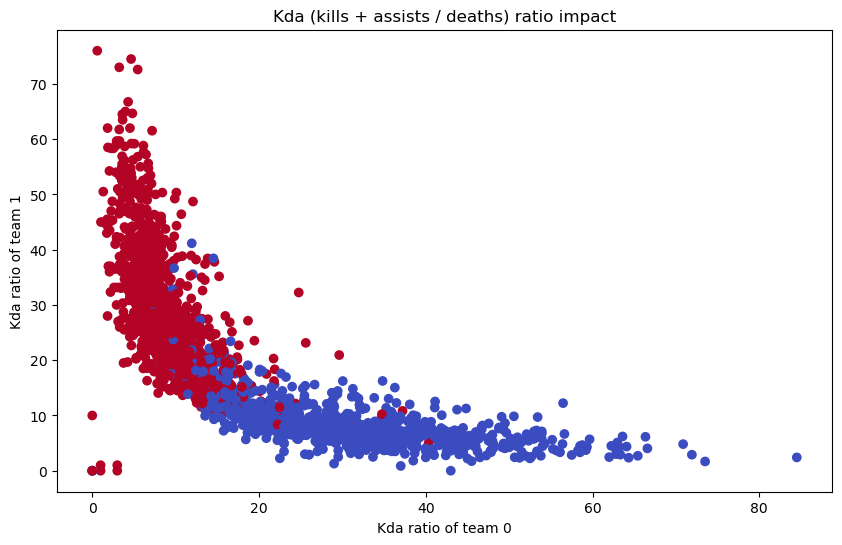

In [84]:
plt.figure(figsize=(10,6))
plt.title('Kda (kills + assists / deaths) ratio impact')
plt.scatter(data_sample["challenges.kda_0"], data_sample["challenges.kda_1"], c=data_sample["win"], cmap='coolwarm_r',)
plt.xlabel('Kda ratio of team 0')
plt.ylabel('Kda ratio of team 1')
plt.show()

We confirm here that kda is very important to win.

As league of legends is a snowball game (more golds equals more damages equals more gold), it's normal to see that a lot of features are correlated. 

So we will need to use a ridge regression to eliminate multicollinearity of our features.
LASSO ?

# Jalon 2

Nous voulons faire une régression logistique pénalisée (Ridge).

In [85]:
data = pd.read_csv('matchs_dataset.csv')
target = data['win']
data.drop(columns='win', inplace=True)

In [86]:
data

allInPings_0  assistMePings_0  assists_0  baronKills_0  basicPings_0  \
0               10               52         53             2             0   
1                4                7         74             1             0   
2                0               28         23             0             0   
3                1                4         15             0             0   
4               13               51         54             1             0   
...            ...              ...        ...           ...           ...   
3838             0               37         66             1             0   
3839             6               32         53             0             0   
3840             6               48         53             1             0   
3841             5                8         16             0             0   
3842             1                4         28             0             0   

      bountyLevel_0  champExperience_0  champLevel_0  championTransform_0  \
0                16              76252            78                    0   
1                 9              72084            77                    2   
2                 0              44885            59                    0   
3                 1              51233            64                    0   
4                 1              73516            77                    0   
...             ...                ...           ...                  ...   
3838              1              74780            78                    0   
3839              0              70681            75                    0   
3840             10              75051            78                    0   
3841              0              49733            63                    0   
3842              0              55555            68                    0   

      commandPings_0  consumablesPurchased_0  damageDealtToBuildings_0  \
0                 82                      33                     16971   
1                 28                      18                     25142   
2                 34                      19                     12308   
3                 37                      13                     10292   
4                 97                      38                     17393   
...              ...                     ...                       ...   
3838              40                      26                      8412   
3839              58                      18                      5308   
3840              43                      20                     29850   
3841              38                      10                      5558   
3842               8                      26                      1912   

      damageDealtToObjectives_0  damageDealtToTurrets_0  \
0                         80671                   16971   
1                         89125                   25142   
2                         38095                   12308   
3                         44376                   10292   
4                         37231                   17393   
...                         ...                     ...   
3838                      48310                    8412   
3839                      43028                    5308   
3840                      94259                   29850   
3841                      26607                    5558   
3842                      29152                    1912   

      damageSelfMitigated_0  dangerPings_0  deaths_0  detectorWardsPlaced_0  \
0                    143109              0        33                     23   
1                     84676              0        24                      6   
2                     94651              0        31                      6   
3                     66732              0        41                      6   
4                    122815              0        36                     23   
...                     ...            ...       ...                    

In [91]:
#Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=42)

In [92]:
#Creation of pipeline with StandardScaler and Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

logreg = LogisticRegression()
pip = make_pipeline(StandardScaler(), LogisticRegression()) #TODO add parameters to LogReg for ridge (l2 parameter)

pip.fit(x_train, y_train)
#Cross validation to check the accuracy of the model
cross_val_score(pip, x_train, y_train, cv=5, scoring='accuracy').mean()

0.9977695167286246

In [93]:
#Display weigths of the model to see which variables are the most important
pip.score(x_test, y_test)

1.0

In [95]:
#We check if a feature is spoiling the model
for col in data.columns:
    pip = make_pipeline(StandardScaler(), LogisticRegression())
    
    pip.fit(x_train, y_train)   
    x_train_copy = x_train.copy()
    #If score is higher than 0.9, we print the column and the score
    score = cross_val_score(pip, x_train, y_train, cv=5, scoring='accuracy').mean()
    if score > 0.9:
        print(col, score)


allInPings_0 0.9977695167286246
assistMePings_0 0.9977695167286246
assists_0 0.9977695167286246
baronKills_0 0.9977695167286246
basicPings_0 0.9977695167286246
bountyLevel_0 0.9977695167286246
champExperience_0 0.9977695167286246
champLevel_0 0.9977695167286246
championTransform_0 0.9977695167286246
commandPings_0 0.9977695167286246
consumablesPurchased_0 0.9977695167286246
damageDealtToBuildings_0 0.9977695167286246
damageDealtToObjectives_0 0.9977695167286246
damageDealtToTurrets_0 0.9977695167286246
damageSelfMitigated_0 0.9977695167286246
dangerPings_0 0.9977695167286246
deaths_0 0.9977695167286246
detectorWardsPlaced_0 0.9977695167286246
doubleKills_0 0.9977695167286246
dragonKills_0 0.9977695167286246
enemyMissingPings_0 0.9977695167286246
enemyVisionPings_0 0.9977695167286246
firstBloodAssist_0 0.9977695167286246
firstBloodKill_0 0.9977695167286246
firstTowerAssist_0 0.9977695167286246
firstTowerKill_0 0.9977695167286246
getBackPings_0 0.9977695167286246
goldEarned_0 0.997769516

KeyboardInterrupt: 